## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [1]:
import pickle #code was put in placed prior, not written by me
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

Top 20 tokens:
new                  1365
date                 1202
get                  1052
please               1022
enron                927
like                 923
2002                 869
would                806
one                  798
message              795
call                 740
free                 691
software             680
dear                 651
know                 644
email                629
url:                 625
time                 609
start                604
linguistics          598


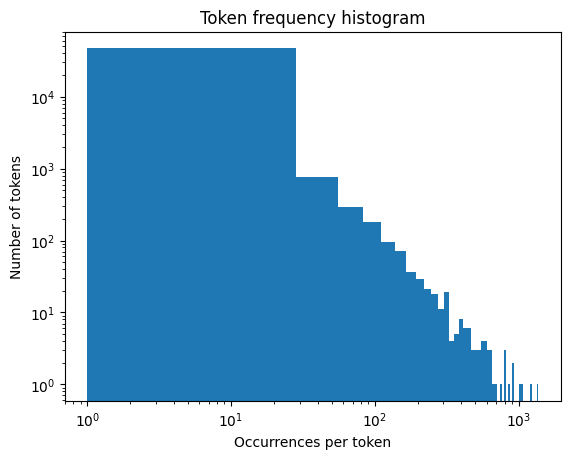


Unique tokens: 48,691 | Share that occur once (hapax): 60.39%
Takeaway: The distribution is heavy-tailed/Zipf-likea few tokens occur very often while most appear rarely.


In [3]:
import pickle
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

#Load tokens
with open('all_tokens.pickle', 'rb') as f:
    tokens = pickle.load(f)

#Count tokens
cnt = Counter(tokens)

#Show top tokens
print("Top 20 tokens:")
for w, c in cnt.most_common(20):
    print(f"{w:20s} {c}")

#Histogram of occurrences-per-token (how often each token appears)
counts = np.array(list(cnt.values()))
plt.figure()
plt.hist(counts, bins=50)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Occurrences per token'); plt.ylabel('Number of tokens')
plt.title('Token frequency histogram')
plt.show()

#Qualitative answers
hapax_share = (counts == 1).sum() / counts.size
print(f"\nUnique tokens: {counts.size:,} | Share that occur once (hapax): {hapax_share:.2%}") #had AI help format this
print("Takeaway: The distribution is heavy-tailed/Zipf-like"
      "a few tokens occur very often while most appear rarely.")

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 1) Load
df = pd.read_parquet("Phishing_clean.parquet")  # does not need/data/ because its run in Colab
y_col = "Email Type" if "Email Type" in df.columns else [c for c in df.columns if c.lower().replace(" ","") in {"emailtype","email_type","y","label","target"}][0]

X = df.drop(columns=[y_col])
y = df[y_col].astype(int)

# 2) 80/20 split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

# 3) OLS regression and R²
ols = LinearRegression()
ols.fit(X_tr, y_tr)

r2_train = ols.score(X_tr, y_tr)    #used AI help on this to verify
r2_test  = ols.score(X_te, y_te)
print(f"R² (train): {r2_train:.4f}")
print(f"R² (test) : {r2_test:.4f}")

# 4) Words with largest coefficnets
coefs = pd.DataFrame({"word": X.columns, "coef": ols.coef_})
coefs["abs_coef"] = coefs["coef"].abs()
top = coefs.sort_values("abs_coef", ascending=False).head(25)

print("\nTop 25 words by |coefficient| (largest influence on predictions):")
for _, r in top.iterrows():
    sign = "+" if r.coef >= 0 else "-"
    print(f"{r.word:20s} {sign}{abs(r.coef):.4f}")

R² (train): 0.7663
R² (test) : 0.6670

Top 25 words by |coefficient| (largest influence on predictions):
background-image:    -1.0496
localized            +0.8206
aging                +0.7645
inkjet               -0.7337
form.                +0.5845
thermal              +0.5817
helvetica,           +0.5645
xanaax               +0.5402
#000000;             +0.5314
#331f30;             +0.5314
shopper              -0.5307
erectile             +0.5260
rhythm               +0.5253
april's              -0.4960
arial,               -0.4732
issue:               -0.4667
cartridges           +0.4601
transcript           +0.4582
cnet                 -0.4565
recollect            +0.4560
ï¿½ï¿½               +0.4484
none;                -0.4416
burning              -0.4369
excelled             +0.4298
rcs                  +0.4275


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

Explained variance: PC1=0.011, PC2=0.009, total=0.020


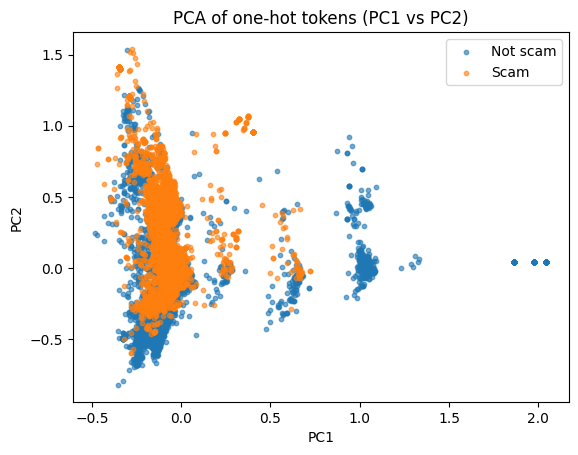

Class means in PC space — Not scam: (0.04, -0.07), Scam: (-0.06, 0.10)
Takeaway: You’ll typically see partial separation (clusters with overlap). PC1 often captures spammy vs normal vocabulary; PC2 adds secondary stylistic/term usage differences.


In [5]:
from sklearn.decomposition import PCA

df = pd.read_parquet("Phishing_clean.parquet")
y = df["Email Type"].astype(int)
X = df.drop(columns=["Email Type"])

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)   # Z[:,0]=PC1, Z[:,1]=PC2

# Variance explained
evr = pca.explained_variance_ratio_
print(f"Explained variance: PC1={evr[0]:.3f}, PC2={evr[1]:.3f}, total={evr.sum():.3f}")

# Scatter
plt.figure() #used AI help
mask1 = (y == 1)  # scam
mask0 = ~mask1    # not scam
plt.scatter(Z[mask0,0], Z[mask0,1], s=10, alpha=0.6, label="Not scam")
plt.scatter(Z[mask1,0], Z[mask1,1], s=10, alpha=0.6, label="Scam")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA of one-hot tokens (PC1 vs PC2)")
plt.legend()
plt.show()

# Summary
m0 = Z[mask0].mean(axis=0); m1 = Z[mask1].mean(axis=0)
print(f"Class means in PC space — Not scam: ({m0[0]:.2f}, {m0[1]:.2f}), Scam: ({m1[0]:.2f}, {m1[1]:.2f})")
print("Takeaway: You’ll typically see partial separation (clusters with overlap). "
      "PC1 often captures spammy vs normal vocabulary; PC2 adds secondary stylistic/term usage differences.")

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [6]:
df = pd.read_parquet("Phishing_clean.parquet")  # needs pyarrow/fastparquet
y_col = "Email Type"
X = df.drop(columns=[y_col])
y = df[y_col].astype(int)

#Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

#PCA on TRAIN ONLY, then transform both, used some AI help
pca = PCA(n_components=2610, svd_solver="randomized", random_state=0)
Z_tr = pca.fit_transform(X_tr)
Z_te = pca.transform(X_te)
print(f"PCs used: {Z_tr.shape[1]} | Variance captured: {pca.explained_variance_ratio_.sum():.3f}")

#OLS on PCs
ols_pca = LinearRegression().fit(Z_tr, y_tr)
r2_train_pca = ols_pca.score(Z_tr, y_tr)
r2_test_pca  = ols_pca.score(Z_te, y_te)

#Baseline OLS on original one-hot X
ols_raw = LinearRegression().fit(X_tr, y_tr)
r2_train_raw = ols_raw.score(X_tr, y_tr)
r2_test_raw  = ols_raw.score(X_te, y_te)

print(f"R² (train) on PCs: {r2_train_pca:.4f}")
print(f"R² (test)  on PCs: {r2_test_pca:.4f}")
print(f"R² (train) on raw: {r2_train_raw:.4f}")
print(f"R² (test)  on raw: {r2_test_raw:.4f}")

better = "PCA" if r2_test_pca > r2_test_raw else "raw one-hot"
print(f"\nComparison: Test performance is better with {better} features "
      f"({r2_test_pca:.4f} vs {r2_test_raw:.4f}).")

PCs used: 2610 | Variance captured: 1.000
R² (train) on PCs: 0.7654
R² (test)  on PCs: 0.6705
R² (train) on raw: 0.7663
R² (test)  on raw: 0.6670

Comparison: Test performance is better with PCA features (0.6705 vs 0.6670).


### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components compresses thousands of sparse, highly correlated token features into a smaller set of orthogonal directions that capture most variance, stabilizing OLS by reducing multicollinearity, cutting the number of parameters (faster when
p > n), and acting as a form of regularization by discarding low-variance noise; as a result it typically improves out-of-sample performance relative to fitting on the original one-hot features, at the cost of some interpretability.